# STEP.1 必要なライブラリのインポート

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import pydotplus
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from IPython.display import Image
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier

from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam
from tensorflow.compat.v1.keras.models import load_model

# STEP.2 CSVファイルの読み込み

In [2]:
# CSVファイルの読み込み
df = pd.read_csv('ks-projects-201801.csv')
df.head(3)

# 使用するCPU数を指定しておく
cpu_cnt=-1

In [3]:
# 件数の確認
print(len(df))

378661


# STEP.3 欠損値の処理

In [4]:
# 欠損値の確認
df.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [5]:
# 暫定で０埋めにする
df['usd pledged'] = df['usd pledged'].fillna('0')
df.isnull().sum()

ID                  0
name                4
category            0
main_category       0
currency            0
deadline            0
goal                0
launched            0
pledged             0
state               0
backers             0
country             0
usd pledged         0
usd_pledged_real    0
usd_goal_real       0
dtype: int64

※↑usd pledgedは後で消すことになる  
本来であれば、平均値・中央値で埋める等検討する  
もし平均値をとる場合は、事前にデータの分布・分散を確認する（90点・95点・5点、の場合は平均値を使わない方が良い）  

# STEP.4 ダミー変数の作成

## STEP4-1.日付データの処理

仮説として、クラウドファンディングが発表された日と締め切りまでの日数差が影響を及ぼしているとして、説明変数に加える

In [6]:
# 日付型に変換
df['deadline'] = pd.to_datetime(df['deadline'])
df['launched'] = pd.to_datetime(pd.to_datetime(df['launched']).dt.strftime('%Y-%m-%d'))

In [7]:
# launched と deadline の差をとって、日数を計算
df['datenum'] = (df['deadline']-df['launched']).astype('timedelta64[D]')

## STEP4-2.目的変数の処理

目的変数は、成功する場合のみをターゲットとするため、成功の場合は1、成功以外の場合は2とする

In [8]:
df.loc[df['state'] == 'successful', 'state_num'] = 1
df.loc[df['state'] != 'successful', 'state_num'] = 0

## STEP4-3.カテゴリ値の処理

カテゴリ値は事前にカテゴリ値毎に目的変数の件数を確認し、極端に偏っていないかなどを確認する

### categoryの確認

In [9]:
# カテゴリ値の種別を確認
vc = df['category'].value_counts()
print(vc)
print(type(vc))

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Makerspaces            238
Printing               238
M

In [10]:
# 件数上位10カテゴリの分布を確認しておおよその傾向をつかむ
df_wk = df.loc[:,['category', 'state_num']]
df_wk = df_wk[df_wk['category'].isin(['Product Design' , 'Documentary', 'Music', 'Tabletop Games', 'Shorts', 'Video Games', 'Food', 'Film & Video'])]
len(df_wk)

114148

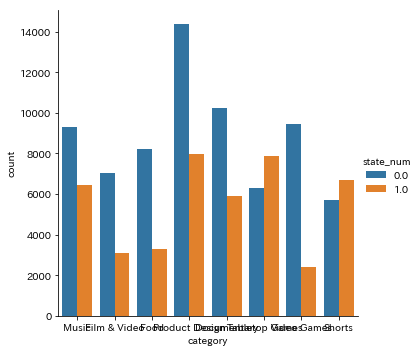

In [11]:
sns.catplot(x="category", hue="state_num", data=df_wk, kind="count")

↑ categoryは特定カテゴリ値での相関が強すぎる結果はないはずなので説明変数として有効

### main_categoryの確認

In [12]:
vc = df['main_category'].value_counts()
print(vc)

Film & Video    63585
Music           51918
Publishing      39874
Games           35231
Technology      32569
Design          30070
Art             28153
Food            24602
Fashion         22816
Theater         10913
Comics          10819
Photography     10779
Crafts           8809
Journalism       4755
Dance            3768
Name: main_category, dtype: int64


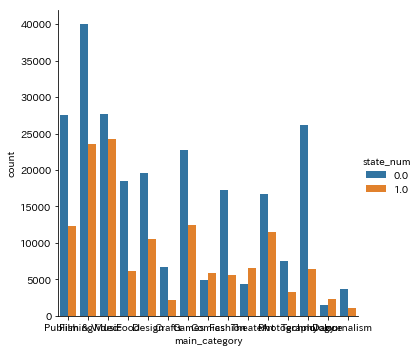

In [13]:
sns.catplot(x="main_category", hue="state_num", data=df, kind="count")

main_categoryは特定カテゴリ値での相関が強すぎる結果はないはずなので説明変数として有効

### currencyカテゴリの確認

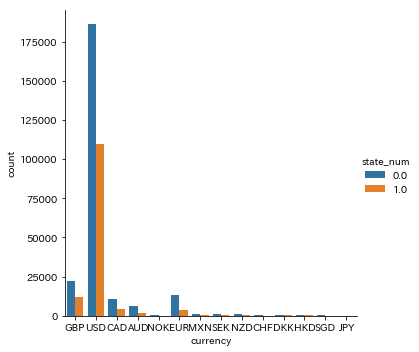

In [14]:
sns.catplot(x="currency", hue="state_num", data=df, kind="count")

currencyは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSDしかないのであれば説明変数で不要か

### countryカテゴリの確認

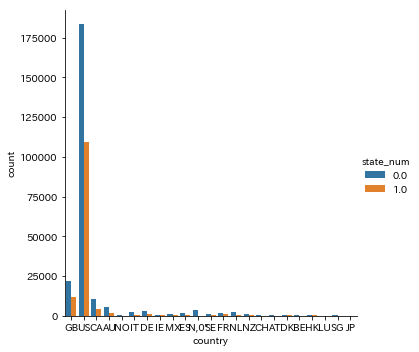

In [15]:
sns.catplot(x="country", hue="state_num", data=df, kind="count")

countryは特定カテゴリ値での相関が強すぎる結果はないはずだが、そもそもUSAしかないのであれば説明変数で不要か

## STEP4-4.カテゴリ値の変換（OneHotEncoding）

In [16]:
# OneHotEncoding
df = pd.get_dummies(df, columns=['category','main_category'])

#### ※OneHotEncodinを実施したいが、学習に時間がかかりすぎるので今回はカテゴリ値に変換することで我慢する

## STEP4-4.カテゴリ値の変換（区分値）

In [17]:
# カテゴリ値版
# categoryをカテゴリ値に変換
#labels, uniques = pd.factorize(df['category'])
#df['category'] = labels

# main_categoryをカテゴリ値に変換
#labels, uniques = pd.factorize(df['main_category'])
#df['main_category'] = labels


## STEP4-5.一次前処理結果の確認

In [18]:
df.describe()

,ID,goal,pledged,backers,usd_pledged_real,usd_goal_real,datenum,state_num,category_3D Printing,category_Academic,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.786610e+05,3.786610e+05,378661.000000,378661.000000,378661.000000,378661.000000,...,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.000000,378661.00000
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,9.058924e+03,4.545440e+04,34.481095,0.353762,0.001804,0.002419,...,0.060254,0.167921,0.064971,0.093041,0.012557,0.137109,0.028466,0.105303,0.086011,0.02882
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,9.097334e+04,1.152950e+06,65.909173,0.478137,0.042432,0.049124,...,0.237958,0.373796,0.246475,0.290490,0.111354,0.343963,0.166300,0.306943,0.280381,0.16730
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,1.000000e-02,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,3.100000e+01,2.000000e+03,30.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,6.243300e+02,5.500000e+03,30.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,4.050000e+03,1.550000e+04,37.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,1.663614e+08,16739.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


# STEP.5 説明変数・目的変数の取り出し

## STEP5-1.不要説明変数の削除

以下説明変数は不要  
　- ID：恐らくlaunched毎に新しく振られるので意味がない  
　- currency：基礎解析結果、ほとんどUSDなので不要と判断  
　- country：基礎解析結果、ほとんどUSAなので不要と判断  
　- name：もし仮にネーミングが効くなら言語処理をしなければいけないので、今回はパス  
　- deadline：launchedとの日数差を説明変数にしたので不要  
　- launched：同↑  
　- state：目的変数として前処理したので不要  
　- backers：募集した結果集まった人数だと思われるので、予測時点では使えないので削除  
　- pledged：募集した結果集まった金額だと思われるので、予測時点では使えないので削除  
  - usd_pledged_real：募集した結果集まった金額だと思われるので、予測時点では使えないので削除  
　- usd pledged：usd_pledged_realにより正確な値が入っていると思われるので削除  

In [19]:
# 不要な説明変数の設定
drop_col = ['ID', 'currency', 'country', 'name','deadline','launched','state','backers','pledged','usd pledged', 'usd_pledged_real']

In [20]:
# 不要列の削除
df=df.drop(drop_col, axis=1)
df.head(3)

,goal,usd_goal_real,datenum,state_num,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,1000.0,1533.95,59.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,30000.0,30000.00,60.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,45000.0,45000.00,45.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## STEP5-2.説明変数間の相関を確認

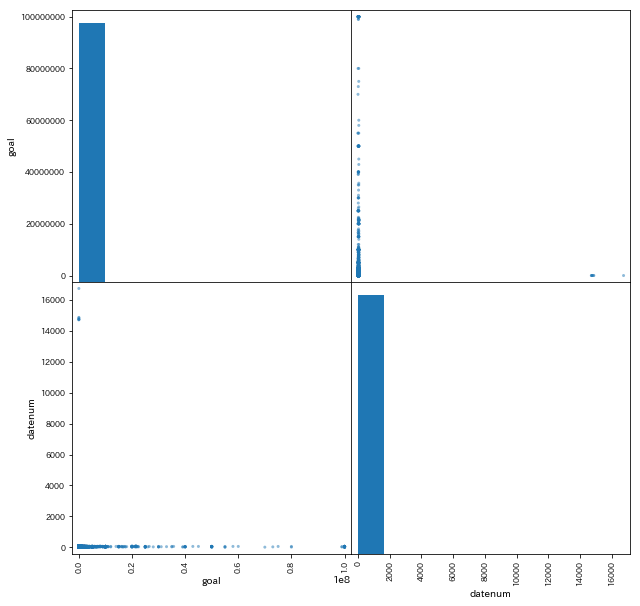

In [21]:
df_wk = df.loc[:,['goal', 'datenum']]
pd.plotting.scatter_matrix(df_wk, figsize=(10,10))
plt.show()

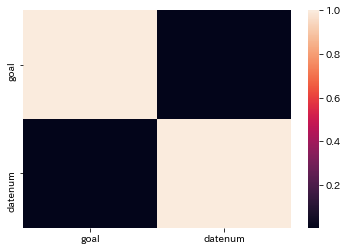

In [22]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_wk.corr())
plt.show()

# メモリ食うので削除
del df_wk

恐らく相関が強すぎる説明変数はなくなったのでOK  
いったん使用する説明変数はここで確定させる

# STEP.6 外れ値処理

## STEP6-1.箱ひげ図でデータの分布を確認する

goal          AxesSubplot(0.125,0.125;0.352273x0.755)
datenum    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

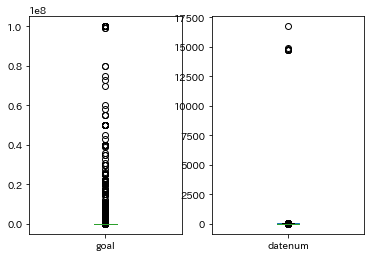

In [23]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

明らかに外れ値があることが見て取れるので削除しにかかる  
念のため、統計量も確認しておく

In [24]:
# 統計量を再確認する
df_wk.describe()

,goal,datenum
count,3.786610e+05,378661.000000
mean,4.908079e+04,34.481095
std,1.183391e+06,65.909173
min,1.000000e-02,1.000000
25%,2.000000e+03,30.000000
50%,5.200000e+03,30.000000
75%,1.600000e+04,37.000000
max,1.000000e+08,16739.000000


## STEP6-2.外れ値の削除処理

3σより外の値は外れ値とみなして削除する

In [25]:
# 3σで削除する関数定義
def sigma3(df, col):
    mean = df[col].mean()
    sigma = df[col].std()
    low = mean - 3 * sigma
    high = mean + 3 * sigma
    df = df[(df[col]>low) & (df[col]<high)]
    sns.distplot(df[col])
    return df

### datenum

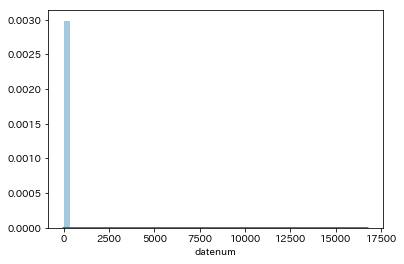

In [26]:
col = 'datenum'
# 現状の散布図確認
sns.distplot(df[col])

In [27]:
df[col].describe()

count    378661.000000
mean         34.481095
std          65.909173
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max       16739.000000
Name: datenum, dtype: float64

↑MAX値が16739日のデータがあるので明らか外れ値

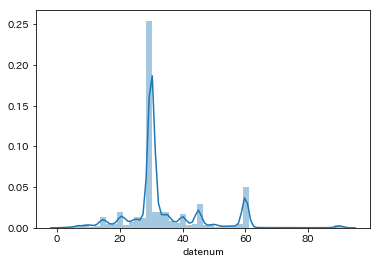

In [28]:
# 3σより外の値を消す
df = sigma3(df, col)

In [29]:
df[col].describe()

count    378654.000000
mean         34.203394
std          12.793171
min           1.000000
25%          30.000000
50%          30.000000
75%          37.000000
max          92.000000
Name: datenum, dtype: float64

おさまったっぽいのでいったんこれでヨシとする

### goal

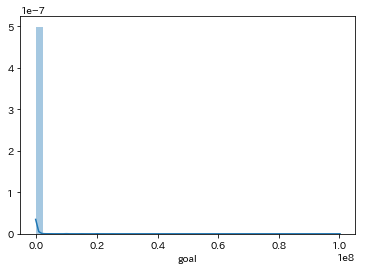

In [30]:
col = 'goal'

# 現状の散布図確認
sns.distplot(df[col])

In [31]:
df[col].describe().apply(lambda x: format(x, 'f'))

count       378654.000000
mean         49081.600876
std        1183402.182306
min              0.010000
25%           2000.000000
50%           5200.000000
75%          16000.000000
max      100000000.000000
Name: goal, dtype: object

↑MAX値が100000000.000000のデータがあるので明らか外れ値

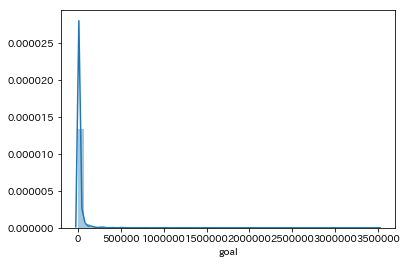

In [32]:
# 3σより外の値を消す
df = sigma3(df, col)

In [33]:
df[col].describe().apply(lambda x: format(x, 'f'))

count     378249.000000
mean       25619.495415
std       111742.421127
min            0.010000
25%         2000.000000
50%         5100.000000
75%        16000.000000
max      3500000.000000
Name: goal, dtype: object

まだ外れ値っぽいのでもう一回やる

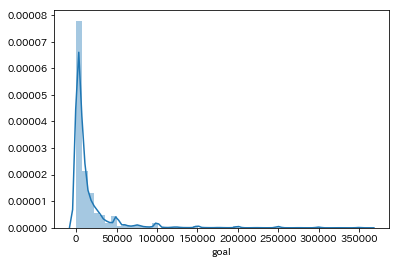

In [34]:
df = sigma3(df, col)

In [35]:
df[col].describe().apply(lambda x: format(x, 'f'))

count    374678.000000
mean      17231.733562
std       35237.054407
min           0.010000
25%        2000.000000
50%        5000.000000
75%       15000.000000
max      360360.000000
Name: goal, dtype: object

おさまったっぽいのでいったんこれでヨシとする

## STEP6-3.再度、箱ひげ図でデータの分布を確認する

goal          AxesSubplot(0.125,0.125;0.352273x0.755)
datenum    AxesSubplot(0.547727,0.125;0.352273x0.755)
dtype: object

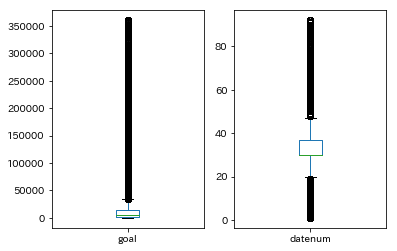

In [36]:
# いったん箱ひげ図で確認
df_wk = df.loc[:,['goal', 'datenum']]
df_wk.plot(kind='box', subplots=True, sharex=True)

まぁそれなりっぽくなったので、これでOK？

## STEP6-4.データ件数がどの程度減ったか確認する

In [37]:
len(df)

374678

件数 378661→374678  
3,983件減少しているが、370,000件あれば学習には使えると思うので、これでヨシ

## STEP6-5.説明変数と目的変数のデータを用意する

In [38]:
y = df['state_num'].values
X = df[df.columns[df.columns != 'state_num']]

In [39]:
df.describe()

,goal,usd_goal_real,datenum,state_num,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,...,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000
mean,17231.733562,16688.087877,34.134118,0.357168,0.001794,0.002418,0.008421,0.001828,0.000681,0.006651,...,0.060649,0.166941,0.064736,0.092551,0.012555,0.138121,0.028705,0.106131,0.084275,0.028940
std,35237.054407,34432.991052,12.756912,0.479166,0.042312,0.049115,0.091377,0.042719,0.026079,0.081282,...,0.238686,0.372923,0.246059,0.289803,0.111343,0.345028,0.166975,0.308006,0.277800,0.167637
min,0.010000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,2000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.000000,5139.010000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.000000,15000.000000,37.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,360360.000000,570794.870000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# STEP.7 機械的説明変数選択

## STEP7-1.ステップワイズ法(重くて帰ってこないので中断)

In [40]:
#estimator = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, n_jobs=cpu_cnt)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
#rfecv = RFECV(estimator, cv=10, scoring='accuracy')

#rfecv.fit(X, y)

In [41]:
# 特徴のランキングを表示（1が最も重要な特徴）
#print('Feature ranking: \n{}'.format(rfecv.ranking_))

全部重要！

## STEP7-2.埋め込み法

In [42]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10, n_jobs=cpu_cnt)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X, y)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001,
                                  fit_intercept=True, max_iter=1000,
                                  n_alphas=100, n_jobs=-1, normalize=True,
                                  positive=False, precompute='auto',
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, verbose=False),
                max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [43]:
# get_support関数で使用する特徴のインデックスを使用
# Trueになっている特徴が使用する特徴
sfm.get_support()

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [44]:
df.describe()

,goal,usd_goal_real,datenum,state_num,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,...,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000,374678.000000
mean,17231.733562,16688.087877,34.134118,0.357168,0.001794,0.002418,0.008421,0.001828,0.000681,0.006651,...,0.060649,0.166941,0.064736,0.092551,0.012555,0.138121,0.028705,0.106131,0.084275,0.028940
std,35237.054407,34432.991052,12.756912,0.479166,0.042312,0.049115,0.091377,0.042719,0.026079,0.081282,...,0.238686,0.372923,0.246059,0.289803,0.111343,0.345028,0.166975,0.308006,0.277800,0.167637
min,0.010000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,2000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.000000,5139.010000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.000000,15000.000000,37.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,360360.000000,570794.870000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
# 削除すべき特徴の名前を取得 
removed_idx  = ~sfm.get_support()
X.columns[removed_idx]

Index(['goal', 'usd_goal_real', 'category_Conceptual Art', 'category_Design',
       'category_Fantasy', 'category_Fashion', 'category_Graphic Design',
       'category_Music', 'category_Photography', 'category_Woodworking',
       'main_category_Film & Video', 'main_category_Games'],
      dtype='object')

埋め込み法をやってみたものの、さすがにこれだけ消すと全く予測できなくなりそうなので、いったん残す  
後で余裕があれば、消してやってみる  

# STEP.8 学習用データ準備

## STEP8-1.ホールドアウト

In [46]:
# 全データのうち、何%をテストデータにするか（今回は20%に設定）
test_size = 0.2

# ホールドアウト法を実行（テストデータはランダム選択）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) 

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936


## STEP8-2. 説明変数の標準化

In [47]:
stdsc = StandardScaler()

X_train_kf = stdsc.fit_transform(X_train)
X_test_kf = stdsc.fit_transform(X_test)

# 件数に誤りがないか確認する
print('X_train:',len(X_train))
print('y_train:',len(y_train))
print('X_test:',len(X_test))
print('y_test:',len(y_test))
print('X_train_kf:',len(X_train_kf))
print('X_test_kf:',len(X_test_kf))

X_train: 299742
y_train: 299742
X_test: 74936
y_test: 74936
X_train_kf: 299742
X_test_kf: 74936


## STEP8-3.検定を関数化しておく

In [48]:
# 交差検定
def fx_cross_validate(estimator,X, y):
    scoring = {"accuracy": "accuracy"
               , "recall": "recall"
               , "precision":"precision"
               , "log_loss":"neg_log_loss"
               , "AUC":"roc_auc"}
    
    scores = cross_validate(estimator, X, y, cv=5, scoring=scoring)
    
    print('Cross-Validation scores(accuracy): {}'.format(scores['test_accuracy']))
    print('Cross-Validation scores(recall): {}'.format(scores['test_recall']))
    print('Cross-Validation scores(precision): {}'.format(scores['test_precision']))
    print('Cross-Validation scores(log_loss): {}'.format(scores['test_log_loss']))
    print('Cross-Validation scores(AUC): {}'.format(scores['test_AUC']))
    print('')
    print('Average score(accuracy): {}'.format(np.mean(scores['test_accuracy'])))
    print('Average score(recall): {}'.format(np.mean(scores['test_recall'])))
    print('Average score(precision): {}'.format(np.mean(scores['test_precision'])))
    print('Average score(log_loss): {}'.format(np.mean(scores['test_log_loss'])))
    print('Average score(AUC): {}'.format(np.mean(scores['test_AUC'])))

In [49]:
# ROC曲線
def fx_roc_curve(y,y_predict):
    
    # 一応、モデルのスコアも再度表示
    score_acs = accuracy_score(y_test, y_pred_test)
    score_logloss = log_loss(y_test, y_pred_test)
    score_auc = roc_auc_score(y_test, y_pred_test)
    
    print('acs:', score_acs)
    print('log_loss:-', score_logloss)
    print('AUC:', score_auc)
    
    # ROC曲線の情報を取得
    fpr, tpr, thresholds = roc_curve(y, y_predict)
    
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%score_auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)

In [50]:
def fx_confusion_matrix(y,y_predict):    
    
    conf_mat = pd.DataFrame(confusion_matrix(y, y_predict), 
                        index=['Actual = Nagative', 'Actual = Positive'], 
                        columns=['predict = Nagative', 'predict = Positive'])
    
    print(conf_mat)

# STEP.9 学習

## 9-1.ロジスティック回帰で交差検定を実施してみる(cross_val_score)

In [51]:
# モデル作成
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, n_jobs=cpu_cnt)

# 交差検定
fx_cross_validate(clf, X_train_kf, y_train)

Cross-Validation scores(accuracy): [0.67744249 0.6775259  0.68106224 0.67857143 0.68567234]
Cross-Validation scores(recall): [0.3505554  0.39148698 0.35013535 0.35453909 0.34679113]
Cross-Validation scores(precision): [0.58076239 0.57131181 0.5908017  0.58269408 0.60514742]
Cross-Validation scores(log_loss): [-0.60225862 -0.60036765 -0.59467249 -0.5978193  -0.59101226]
Cross-Validation scores(AUC): [0.68930463 0.69388958 0.69919355 0.69588257 0.7048156 ]

Average score(accuracy): 0.6800548797014675
Average score(recall): 0.3587015899395286
Average score(precision): 0.586143479660581
Average score(log_loss): -0.5972260652018132
Average score(AUC): 0.6966171849693645


In [52]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.6780452652930501
log_loss:- 11.119956523212384
AUC: 0.5747198249359071


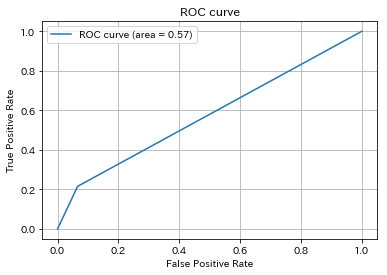

In [53]:
fx_roc_curve(y_test, y_pred_test)

In [54]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               45061                3180
Actual = Positive               20946                5749


まぁこんなもん？

## 9-2.説明変数の重みチェック

In [55]:
# 重みを取得して表示
w0 = clf.intercept_[0]
w1 = clf.coef_[0, 0]
w2 = clf.coef_[0, 1]
w3 = clf.coef_[0, 2]
w4 = clf.coef_[0, 3]
w5 = clf.coef_[0, 4]
w6 = clf.coef_[0, 5]
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}, w4 = {:.3f}, w5 = {:.3f}, w6 = {:.3f}'.format(w0, w1, w2, w3, w4, w5, w6))


w0 = -4.643, w1 = -0.097, w2 = -0.536, w3 = -0.231, w4 = 0.112, w5 = 0.212, w6 = 0.201


In [56]:
X_train.describe()

,goal,usd_goal_real,datenum,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,...,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
count,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,...,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000,299742.000000
mean,17214.851470,16666.891890,34.119863,0.001795,0.002352,0.008367,0.001852,0.000644,0.006726,0.002095,...,0.060742,0.166563,0.064599,0.092806,0.012541,0.138332,0.028421,0.106395,0.084249,0.028755
std,35191.778283,34352.102421,12.747811,0.042328,0.048441,0.091089,0.042990,0.025367,0.081735,0.045725,...,0.238857,0.372586,0.245817,0.290162,0.111281,0.345249,0.166173,0.308343,0.277762,0.167117
min,0.010000,0.010000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2000.000000,2000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.000000,5200.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15000.000000,15000.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,360360.000000,570794.870000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# STEP.11 SVMの実装

## 11-1.SVMの実装(時間かかりすぎで動かず)

In [57]:
#clf = SVC(C=5, kernel='rbf', gamma=1)
#fx_cross_validate(clf, X_train_kf, y_train)

In [58]:
# いったんモデルを作ってみる
#clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
#y_pred_test = clf.predict(X_test_kf)

In [59]:
#fx_roc_curve(y_test, y_pred_test)

## 11-2.LinearSVCの実装

In [60]:
clf = LinearSVC(loss='hinge', C=1.0,class_weight='balanced', random_state=0)
# 交差検定は時間かかるのでいったんパス
#fx_cross_validate(clf, X_train_kf, y_train)

In [61]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


acs: 0.6227714316216505
log_loss:- 13.029216678946351
AUC: 0.6300838295506377


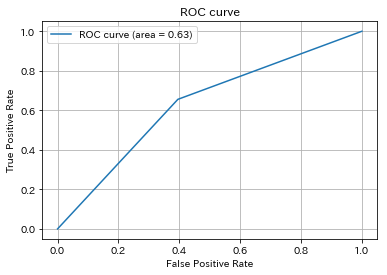

In [62]:
fx_roc_curve(y_test, y_pred_test)

# STEP.12 決定木の実装

In [63]:
clf = DecisionTreeClassifier(criterion="gini", max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)
fx_cross_validate(clf, X_train_kf, y_train)

Cross-Validation scores(accuracy): [0.65482327 0.65564063 0.65418939 0.65316608 0.65215941]
Cross-Validation scores(recall): [0.40936246 0.41136936 0.40940913 0.40742124 0.4043874 ]
Cross-Validation scores(precision): [0.5218038  0.52321026 0.52062437 0.51881129 0.51709937]
Cross-Validation scores(log_loss): [-3.47899139 -3.59980998 -3.58047833 -3.52846172 -3.59525318]
Cross-Validation scores(AUC): [0.65420432 0.64931786 0.64933848 0.65016965 0.64825171]

Average score(accuracy): 0.6539957546744474
Average score(recall): 0.40838991700396504
Average score(precision): 0.5203098177305926
Average score(log_loss): -3.5565989235956166
Average score(AUC): 0.6502564059438428


In [64]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.6458978328173375
log_loss:- 12.230369074367726
AUC: 0.5919803380432513


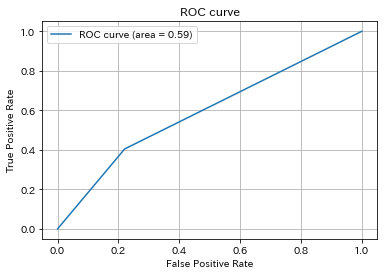

In [65]:
fx_roc_curve(y_test, y_pred_test)

In [66]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               37604               10637
Actual = Positive               15898               10797


In [67]:
# 決定木の描画
#dot_data = StringIO() #dotファイル情報の格納先

# メモリ不足で断念
'''
dot_data = export_graphviz(clf, out_file=None,  
                     feature_names=["category","main_category","goal","usd_goal_real","datenum"],  
                     class_names=["0","1","2","3","4"],  
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())
'''

'\ndot_data = export_graphviz(clf, out_file=None,  \n                     feature_names=["category","main_category","goal","usd_goal_real","datenum"],  \n                     class_names=["0","1","2","3","4"],  \n                     filled=True, rounded=True,  \n                     special_characters=True) \ngraph = pydotplus.graph_from_dot_data(dot_data) \nImage(graph.create_png())\n'

# STEP.13 ランダムフォレストの実装

In [68]:
clf = RandomForestClassifier(n_estimators=10, max_depth=2, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234, n_jobs=cpu_cnt)
fx_cross_validate(clf, X_train_kf, y_train)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Cross-Validation scores(accuracy): [0.64259621 0.64259621 0.64259621 0.64260693 0.64260096]
Cross-Validation scores(recall): [0. 0. 0. 0. 0.]
Cross-Validation scores(precision): [0. 0. 0. 0. 0.]
Cross-Validation scores(log_loss): [-0.63676101 -0.63668273 -0.63658449 -0.63656241 -0.6366664 ]
Cross-Validation scores(AUC): [0.6625182  0.66704171 0.66537789 0.66915937 0.66605094]

Average score(accuracy): 0.6425993021029688
Average score(recall): 0.0
Average score(precision): 0.0
Average score(log_loss): -0.6366514090805123
Average score(AUC): 0.6660296216445091


/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
# いったんモデルを作ってみる
clf.fit(X_train_kf, y_train)

# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.643762677484787
log_loss:- 12.30400122587462
AUC: 0.5


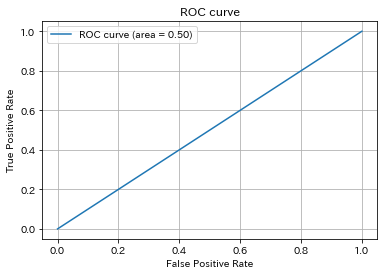

In [70]:
fx_roc_curve(y_test, y_pred_test)

In [71]:
fx_confusion_matrix(y_test, y_pred_test)

                   predict = Nagative  predict = Positive
Actual = Nagative               48241                   0
Actual = Positive               26695                   0


[1.09856642e-01 1.41936344e-01 1.64491547e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.43383211e-02 5.90794703e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.95347137e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.82518695e-02 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

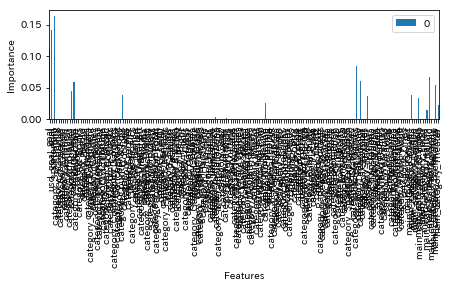

In [72]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
print(clf.feature_importances_)
pd.DataFrame(clf.feature_importances_, index=X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

# STEP.14 XGBoostでの実装

In [73]:
dtrain = xgb.DMatrix(X_train_kf, label=y_train)
dtest = xgb.DMatrix(X_test_kf, label=y_test)

In [74]:
clf = xgb.XGBClassifier()

# ハイパーパラメータ探索
clf_cv = GridSearchCV(clf, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1, n_jobs=cpu_cnt)
clf_cv.fit(X_train_kf, y_train)
print(clf_cv.best_params_, clf_cv.best_score_)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 39.2min finished


{'max_depth': 6, 'n_estimators': 200} 0.6966991612786997


In [75]:
# 改めて最適パラメータで学習
clf = xgb.XGBClassifier(**clf_cv.best_params_, n_jobs=cpu_cnt)
clf.fit(X_train_kf, y_train)
# ホールドアウトのデータで予測
y_pred_test = clf.predict(X_test_kf)

acs: 0.699743781360094
log_loss:- 10.370546376530395
AUC: 0.6287321345725542


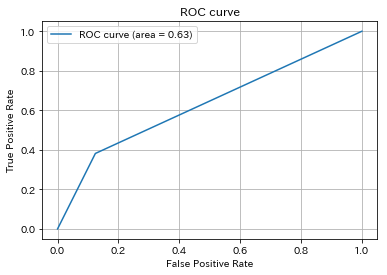

In [76]:
fx_roc_curve(y_test, y_pred_test)

# STEP.15 ニューラルネットワークで実装

In [77]:
# 説明変数が多すぎて計算リソースが足りないのでやめとく